
# NLP pre-processing and visualization using Numpy, Pandas, Scikit Learn, and NLTK

This notebook is intended as an example of how to load, pre-process and analyze the toxicity scored text comment data provided for the 2018 Portland Data Science Group NLP workshop. The code here is not meant to be "the right way" to process and analyze text: there are so many different ways to do this! Instead, I hope that it will help fill in gaps new learners might have so they can start really working with the data.

Setup:
- Load data downloaded from http://dive-into.info/
- Download nltk content (optional)

Text pre-processing:
- Combine multiple ratings for each comment so we have a single rating and toxicity category for each.
- Clean up text by dropping non-alpha characters.
- Optionally drop stop words.
- Use a word stemmer to stem the words.

Dimensionality reduction and visualization:
- Vectorize the pre-processed comment text to counts of each word.
- Apply TFIDF (term frequency–inverse document frequency) to weight words by importance.
- Use Singular Value Decomposition to reduce the 100k+ feature vectors to 4 dimensions.
- Plot position of each comment in 4D SVD space


### Some resources:

[Book about Natural Language Processing.](http://www.nltk.org/book/ch00.html)

[Natural Language Processing Study materials for beginners](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/46073)

[Machine Learning, NLP: Text Classification using scikit-learn, python and NLTK.](https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a) - [code](https://github.com/javedsha/text-classification/blob/master/Text%2BClassification%2Busing%2Bpython%2C%2Bscikit%2Band%2Bnltk.ipynb)

[sklearn tutorial working with text data:](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

[tutorial with NLTK VADER sentiment analysis example](http://nlpforhackers.io/sentiment-analysis-intro/)

[6 Practices to enhance the performance of a Text Classification Model](https://www.analyticsvidhya.com/blog/2015/10/6-practices-enhance-performance-text-classification-model/)

[Machine Learning & Sentiment Analysis: Text Classification using Python & NLTK](http://blog.chapagain.com.np/machine-learning-sentiment-analysis-text-classification-using-python-nltk/)


### Import NLTK components

NLTK is installed in Jupyter by default, but you still need to download the corpus data many of the tools use to process text data. This only needs to be done once. I've commented out the code line that does this, so the first time you run this code, you may need to uncomment it and run this cell, then comment again since you only need to do it once. NLTK will open a dialog allowing you to select what is downloaded - I chose all, but probably "most popular" will suffice. 

In [47]:
import nltk

# uncomment this to download nltk. This needs to be done once, and takes a while. 
#  I downloaded everything, but probably the "popular packages" will suffice.
#nltk.download()


## Set up the notebook plot environment, import some basic modules, and load the data.

Notes:

- You can load the smaller or larger dataset by setting the if statement True or False, respectively.

- We could have loaded the data into Numpy arrays, but here we're loading the data into Pandas dataframes. Pandas is a more powerful and sophisticated module for loading and manipulating data than Numpy, and both Pandas and Numpy are compatible with most of the tools used for data science. Having the data in Pandas is useful for some processing functions, and it's generally useful to know how to use Pandas.

- This block also does a minimal bit of cleanup, by removing the embedded text "NEWLINE_TOKEN" and "TAB_TOKEN".

In [48]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

# set matplotlib environment and import some basics
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 100 # set to -1 to see entire text

# set True to load the smaller data set, False to load the large data set
# NOTE: this code assumes data files are in the same folder as the notebook.
if True:
    # comment filename
    commentfile = 'toxicity_annotated_comments_unanimous.tsv'
    # rating filename
    ratingfile = 'toxicity_annotations_unanimous.tsv'

# full data set
    # comment filename
    commentfile = 'toxicity_annotated_comments.tsv'
    # rating filename
    ratingfile = 'toxicity_annotations.tsv'

# load annotated comments
commentdata = pd.read_table(commentfile)
ratingdata = pd.read_table(ratingfile)

# remove weird tab/newline TOKEN text
commentdata['comment'] = commentdata['comment'].str.replace('NEWLINE_TOKEN',' ')
commentdata['comment'] = commentdata['comment'].str.replace('TAB_TOKEN',' ')

# show shape of each data set
print("commentdata.shape = ",commentdata.shape)
print("ratingdata.shape = ",ratingdata.shape)


commentdata.shape =  (159686, 7)
ratingdata.shape =  (1598289, 4)


## Combine comments and scores into one dataset

The comment and rating data are not the same size, because there is more than one score for each comment by different users. For this analysis, I want to combine all scores for each comment. Here, I compute a mean and median of all scores for each comment. The median score is potentially useful because it is less sensitive to outlier scores, which might be especially helpful for the larger dataset that contains comments with a wider range of scores by different users.

Use Pandas groupby function to calculate the mean and median for each comment, and add them as columns to the comment dataframe. Now we have comments and two measures of score aligned.

Also, create a new toxicity categorical variable (0=not toxic, 1=toxic) by thresholding the median score at 0.

In [49]:
# group all scores by comment ID for each text sample, add mean and median score columns to comment data 
commentdata["mean_score"] = pd.Series(ratingdata.groupby("rev_id",as_index=False).mean()["toxicity_score"])
commentdata["median_score"] = pd.Series(ratingdata.groupby("rev_id",as_index=False).median()["toxicity_score"])
# create catgorical variable toxicity: if median score < 0, toxicity=1, otherwise 0
commentdata["toxicity"] = (commentdata["median_score"] < 0).astype(int)

print("commentdata.shape = ",commentdata.shape)
commentdata.head()

commentdata.shape =  (159686, 10)


,rev_id,comment,year,logged_in,ns,sample,split,mean_score,median_score,toxicity
0,2232.0,This: :One can make an analogy in mathematical terms by envisioning the distribution of opinions...,2002,True,article,random,train,0.4,0.5,0
1,4216.0,"` :Clarification for you (and Zundark's right, i should have checked the Wikipedia bugs page f...",2002,True,user,random,train,0.5,0.0,0
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test,0.1,0.0,0
3,26547.0,`This is such a fun entry. Devotchka I once had a coworker from Korea and not only couldn't s...,2002,True,article,random,train,0.6,0.0,0
4,28959.0,"Please relate the ozone hole to increases in cancer, and provide figures. Otherwise, this articl...",2002,True,article,random,test,0.2,0.0,0


## Feature reduction: 

The goal of most NLP transformation procedures is to convert original text data into numeric features that can be fed into a model. Usually, text is broken down into words, combos of words, or even characters, and each unique combination is called a token and treated as a feature. The problem with unprocessed text is that it tends to generate a very large number of features - large enough that you can easily run out of memory. So, we want to do some things to reduce the number of features as much as possible.

The purpose of the following code is to reduce the number of different words in our text corpus (the combo of all text in our data set), without reducing the useful information about toxicity.


### Stemming:

Stemming and lemmatization are two comman methods for feature reduction with text data. The overall goal here is to reduce the number of word tokens generated from our text by transforming different words that have the same meaning into one token. 

Stemming is the process of reducing words to the root characters common to several forms. For example, walked, walking, walks, walker can be reduced to "walk". Stemming is computationally cheap because it is mostly a process of simply chopping off characters.

Lemmatization goes a step further and tries to infer the meaning of a word in a text, given the sentence context and the word's part of speech, then replace it with its base form, the lemma. For example is, are, were and am can all be reduced to a single token "be" (whereas a stemmer will leave all of these as individual tokens). The lemmatizer is more powerful (i.e. reduces dimensionality better), but is computationally expensive.

For this analysis, I will stick with stemming because it is much faster than lemmatizing.


### Clean up the comment text:

- Drop punctuation, whitespace, numbers, non-letter characters, etc.
- Make all words lower case.
- Drop stop words
- Use the Porter stemmer to stem the words

Note: there are lots of ways to "clean" text, not all of which are helpful - it depends on the application and the text data:
- For example, you might want to keep certain punctuation marks such as "!", which indicate emotion. 
- Instead of eliminating them, you might want to convert certain words or character combos into standardized representations (for example emoticons: :) = "happy")
- Removal of stop words is not advised if you are tokenizing using n-grams, since many stop words modify the meaning of regular words. 


In [50]:
%%time
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords as sw
ps = PorterStemmer()

# set up regex expression to remove all but alpha chars and whitespace
regex = re.compile('[^a-zA-Z\s]') 

drop_stopwords = True # change this to False to keep stop words

# create set of stop words from nltk corpus
stopwords = set(sw.words('english'))

numsamples = commentdata.comment.shape[0]

# transform each sample text:
stemmed_text = []
for text,i in zip(commentdata.comment,range(numsamples)):
    # set to lower case
    text = regex.sub('',text.lower())
    # look at each word in text
    t = []
    for word in word_tokenize(text):
        if len(word) < 30: # drop "words" that are too long (otherwise stem crashes!)
            if not drop_stopwords or word not in stopwords: # drop stopwords
                t.append(ps.stem(word)) # stem the added word
    stemmed_text.append(" ".join(t)) # re-combine list of stemmed words
    if not i%5000: print(i,',', end="")

#stemmed_text = pd.Series(np.array(stemmed_text)) # convert list of sample texts to pandas series
        
print("\nstemmed_text:",stemmed_text[:2])

# completed in ~4 min on my laptop

0 ,5000 ,10000 ,15000 ,20000 ,25000 ,30000 ,35000 ,40000 ,45000 ,50000 ,55000 ,60000 ,65000 ,70000 ,75000 ,80000 ,85000 ,90000 ,95000 ,100000 ,105000 ,110000 ,115000 ,120000 ,125000 ,130000 ,135000 ,140000 ,145000 ,150000 ,155000 ,
stemmed_text: ['one make analog mathemat term envis distribut opinion popul gaussian curv would say consensu would statement repres rang opinion within perhap three standard deviat mean opinion sound arbitrari ad hoc realli belong n encyclopedia articl dont see add anyth use paragraph follow seem much use polit theorist clarifi issu seem issu lock rousseau de toquevil other must debat sr', 'clarif zundark right check wikipedia bug page first bug code make wikipedia work mean line code may error small extra space analog simplifi way tri make someth bold html forget put end youd see someth like word bold instead word bold like viru code somebodi deliber wrote order infect comput damag file wont go around jhk']
Wall time: 2min 42s


## Vectorize the text to generate "bag of words" features

Now that we've cleaned up the text, I can transform each comment text into a set of features. In this example, I create a feature set that consists of counts within each comment of every word that occurred in the data set. Then I use a procedure called TFIDF (term frequency–inverse document frequency) to weight each word based on how common it is overall (common words are weighted lower, since they don't tell us much about the meaning in each comment). 

The result is a set of 100k+ features for each comment, with most cells being 0 (i.e., very sparse data). 

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# use this instead to only vectorize the text (no TFIDF)
#vec_stemmed = CountVectorizer().fit_transform(stemmed_text) 

# The TfidfVectorizer does two things: first it vectorizes the comment text, 
#  and then it applies the TFIDF algorithm to weight every word. 
vec_stemmed = TfidfVectorizer().fit_transform(stemmed_text)

## Further analysis / classification, etc

At this point, I am ready to apply the vectorized text data for further analysis. For example, I could use this to train a Multinomial Naive Baysian classifier to distinguish between toxic and nontoxic comments. In my example here, I will leave that to you to figure out and instead Singular Value Decomposition to reduce the dimensionality of the feature vectors to just 4 feature dimensions and plot the result to see if the toxic vs nontoxic comments can be separated into individual clusters.

Dimensionality reduction and visualization:
- Use Singular Value Decomposition to reduce the 100k+ feature vectors to 4 dimensions.
- Plot position of each comment in 4D SVD space


In [52]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

n_components = 4

coords = TruncatedSVD(n_components).fit_transform(vec_stemmed)
coords = StandardScaler().fit_transform(coords)

print("coords.shape",coords.shape)

coords.shape (159686, 4)


### Plot each feature dimension against the others. 

Nontoxic comments are plotted blue, and toxic comments are red.

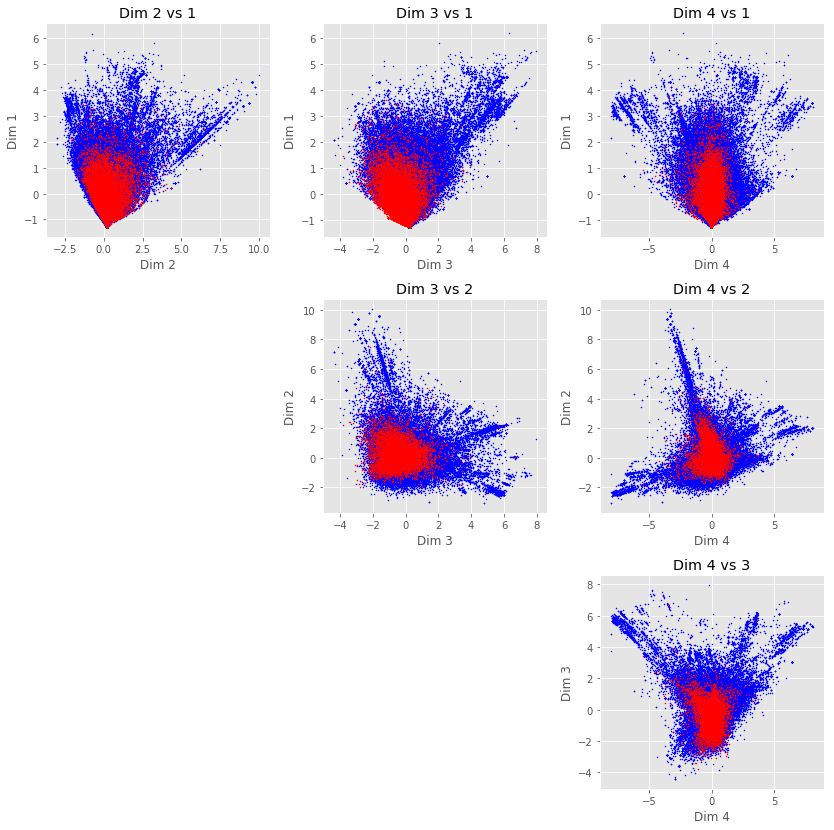

In [53]:
numdims = coords.shape[1]

plt.figure(figsize=(15, 15))
s = 1

numrows = numdims
for i in range(numrows):
    for j in range(i+1):
        if i != j:
            plotnum = j*(numrows)+i+1
            plt.subplot(numrows, numrows, plotnum)
            sa = plt.scatter(coords[:,i],coords[:,j], color='b', s=s, lw=0, label='SVD')
            sa = plt.scatter(coords[commentdata.toxicity==0,i],coords[commentdata.toxicity==0,j], color='b', s=s)
            sa = plt.scatter(coords[commentdata.toxicity==1,i],coords[commentdata.toxicity==1,j], color='r', s=s)
            ta = plt.title("Dim %d vs %d"%(i+1,j+1))
            xl = plt.xlabel("Dim %d"%(i+1))
            yl = plt.ylabel("Dim %d"%(j+1))
            plt.tight_layout()